# Flight Data Analysis

### Introduction

The purpose of this notebook is to perform some exploratory analysis on the flights_medium dataset and to hopefully gain some useful insights. In addition, we would like to create a machine learning model which helps to predict the delay in a flight's arrival time.


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.api as sm

from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score

from tabulate import tabulate

### Import Data

The first step is to import the flights data. We create a dataframe called flights.

In [4]:
# Import data
flights = pd.read_csv("flights_medium.csv")

The first 5 rows in each dataframe are displayed below.

In [5]:
flights.head()

,Date,Airline,Airline_code,Arrival_airport,Arrival_state,Departure_Airport,Departure_State,Departure_actual,Departure_delay,Arrival_actual,Arrival_delay,Arrival_schedule,Departure_schedule,DC_Longitude,DC_Latitude,Longitude,Latitude,Route,Path_order
0,2009-04-24,9E,20363,CVG,KY,BDL,CT,1646,-4,1854,-5,1859,1650,-72.68,41.93,-72.68,41.93,CT to KY,1
1,2009-04-29,9E,20363,CVG,KY,BDL,CT,1640,-10,1834,-25,1859,1650,-72.68,41.93,-72.68,41.93,CT to KY,1
2,2010-04-30,9E,20363,CVG,KY,BDL,CT,1041,-4,1247,-23,1310,1045,-72.68,41.93,-72.68,41.93,CT to KY,1
3,2010-04-15,9E,20363,CVG,KY,BDL,CT,1055,10,1310,0,1310,1045,-72.68,41.93,-72.68,41.93,CT to KY,1
4,2010-12-24,9E,20363,CVG,KY,BDL,CT,1009,-6,1201,-41,1242,1015,-72.68,41.93,-72.68,41.93,CT to KY,1


### EDA

Before doing any analysis, it is worth checking whether there are any missing values. As shown below, there aren't any missing values. This makes life easier for us!

In [6]:
flights.isnull().values.any()

False

The first step of our analysis is to determine the distribution of delays. Below, we plot a CDF plot as well as a histogram to help us visualise the delays distribution. 

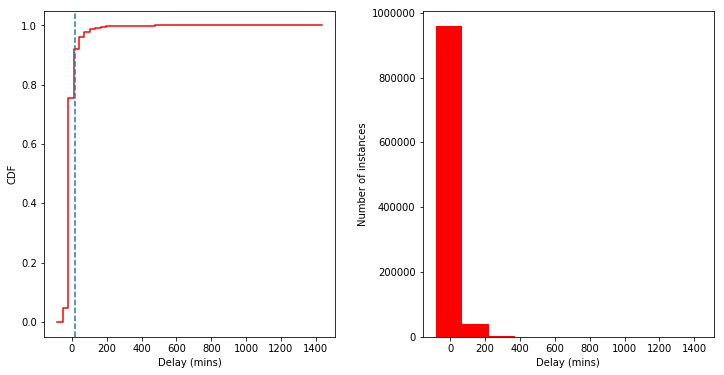

In [7]:
fig, ax = plt.subplots(figsize = (12,6), ncols = 2)

# CDF Plot
ecdf = sm.distributions.ECDF(flights["Arrival_delay"])
x = np.linspace(min(flights["Arrival_delay"]), max(flights["Arrival_delay"]))
y = ecdf(x)

ax[0].step(x,y, color = "red")
ax[0].axvline(x = 20, ls = "dashed")
ax[0].set_xlabel("Delay (mins)")
ax[0].set_ylabel("CDF")

# Histogram
ax[1].hist(flights["Arrival_delay"], bins = 10, color = "red")
ax[1].set_xlabel("Delay (mins)")
ax[1].set_ylabel("Number of instances")

fig.subplots_adjust(wspace=0.3)

plt.show()

As you would probably expect, a large concentration of flights are delayed by a very small amount; the CDF plot suggests around 90% of flights are delayed by less than 20 mins (the dashed blue vertical line is situated at 20 mins). A similar distribution is also seen in the histogram on the right. This suggests that airlines/airports are doing a reasonable job in ensuring that delays are minimised.

One question which immediately springs to mind is to identify which airlines have the largest delays on average. Below, we group the data by "Airline" and then calculate the mean of the "Arrival_delay" column. This gives us the mean delay for each airline. We then sort the airlines in decreasing order of delay and obtain the top 10 results.

In [8]:
# Mean arrival delay by Airline
airline_delay = flights.groupby("Airline")["Arrival_delay"].mean()
airline_delay = airline_delay.sort_values(ascending = False).head(10)
airline_delay

Airline
NW    11.560257
EV     8.943964
XE     8.852151
CO     8.678047
FL     8.473449
B6     8.462789
VX     8.300000
AA     7.796541
MQ     7.138009
TZ     7.090064
Name: Arrival_delay, dtype: float64

For illustrative purposes, a bar chart of the above result has been displayed below. As we can see, airline NW has the largest mean delay of 11.6 minutes.

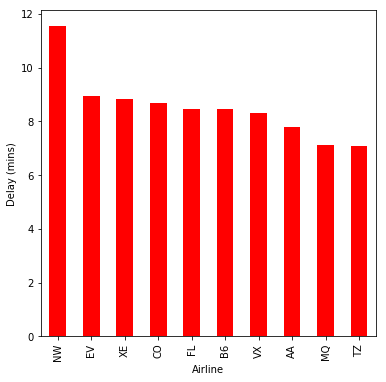

In [9]:
# Graph to illustrate the top 10 airlines which largest mean arrival delay 
fig, ax = plt.subplots(figsize = (6,6))
airline_delay.plot(kind = "bar", color = "red")
ax.set_ylabel("Delay (mins)")
plt.show()

We can then repeat this same process but for "Departure_Airport" rather than airline. This is done below.

In [10]:
# Mean Arrival Delay by Departure Airport
dep_delay = flights.groupby("Departure_Airport")["Arrival_delay"].mean()
dep_delay = dep_delay.sort_values(ascending = False).reset_index()
dep_delay.head()

,Departure_Airport,Arrival_delay
0,ACT,189.0
1,LEX,54.0
2,GPT,53.0
3,XNA,49.5
4,CAK,36.0


It seems strange that flights leaving from airport ACT have such a large delay in their arrival time. One reason to explain this is that maybe there are very few flights leaving from this airport and hence the mean delay time is just based on a very small sample size. To investigate this claim, let's also see how many flights leave each airport. We will have to create a separate dataframe which contains the number of departing flights from each airport. This is done below.

In [11]:
# Number of flights for each Departure Airport
dep_count = flights.groupby("Departure_Airport")["Arrival_delay"].count().reset_index()
dep_count = dep_count.rename(columns = {"Arrival_delay":"Number of Flights"})
dep_count.head()

,Departure_Airport,Number of Flights
0,ABE,2101
1,ABQ,34524
2,ACK,32
3,ACT,1
4,ACY,139


The next step is to merge the 2 dataframes together by using the common "Departure_Airport" column. This gives us a dataframe containing each airport from which a flight departed, the mean delay in arrival time from each airport and the number of flight departures from each airport. We then sort the dataframe in decreasing order of delay. As we initially hypothesised, airport ACT has only flight departing form it (which was significantly delayed). This explains why the mean delay from this airport is so large. This similarly explains why a number of other airports have such a large mean delay.

In [12]:
# Merging the 2 dataframes to get arrival delay and number of flights for each departure airport
dep_delay_join = dep_delay.merge(dep_count, on = "Departure_Airport")
dep_delay_join = dep_delay_join.sort_values("Arrival_delay", ascending = False)
dep_delay_join.head(10)


,Departure_Airport,Arrival_delay,Number of Flights
0,ACT,189.000000,1
1,LEX,54.000000,1
2,GPT,53.000000,1
3,XNA,49.500000,2
4,CAK,36.000000,2
5,CRW,35.750000,4
6,MOB,30.000000,1
7,LMT,20.796053,152
8,HOU,19.728000,125
9,PHF,18.243243,37


To get a better idea of which airports are underperforming, it might be worth filtering the dataframe by airports which have more than 100 flights departing it. This is done below. As can be seen, airports LMT, HOU and GEG seem to have the most significant delays to its departing flights. 

In [13]:
# Selecting departure airports which have more than 100 flights
dep_delay_join[dep_delay_join["Number of Flights"] > 100].head(5)

,Departure_Airport,Arrival_delay,Number of Flights
7,LMT,20.796053,152
8,HOU,19.728000,125
11,GEG,15.639241,158
12,TUL,12.747967,123
13,CIC,11.824242,660


We will now group by route and see which routes have the largest mean delay. This is similar to what we did previously so all the code is in one cell. We created 2 dataframes and merged them to give us the route, mean delay and number of flights. We then filter the dataframe to show the routes which have more than 100 flights as this would give us a more reliable measure of which routes have more significant delays than others.

In [14]:
# Mean Arrival delay for each route
route_delay = flights.groupby("Route")["Arrival_delay"].mean().sort_values(ascending = False).reset_index()

# Number of flights for each route
route_count = flights.groupby("Route")["Arrival_delay"].count().reset_index()

# Rename column
route_count = route_count.rename(columns = {"Arrival_delay":"Number of Flights"})

# Merge the 2 dataframes to give us arrival delay and number of flights for each route
route_delay_join = route_delay.merge(route_count, on = "Route")

# Filter to give us routes with more than 100 flights
route_delay_join[route_delay_join["Number of Flights"] > 100].head(10)

,Route,Arrival_delay,Number of Flights
6,NJ to OK,26.550147,678
10,NJ to GA,17.579463,3165
11,MA to GA,16.746082,319
12,IL to GA,16.709949,3327
13,VA to OK,16.093750,128
14,NJ to PA,15.418251,263
17,MI to CA,14.752427,618
18,WI to PA,13.974790,119
19,VA to FL,13.866561,1259
20,GA to OK,13.665075,1466


As we can see, the route which has a significant number of flights and largest delay time is  NJ to OK.  

The next step of our analysis is to investigate how flight delays vary across the year. It would be worth seeing whether delays are more likey to be larger during certain days of the week, months or even years. To do this, we shall convert the Date column to the relevant format and then group the observations by day, month and year. After grouping, we then calculate the mean delay.

We shall put all this code in the cell below.

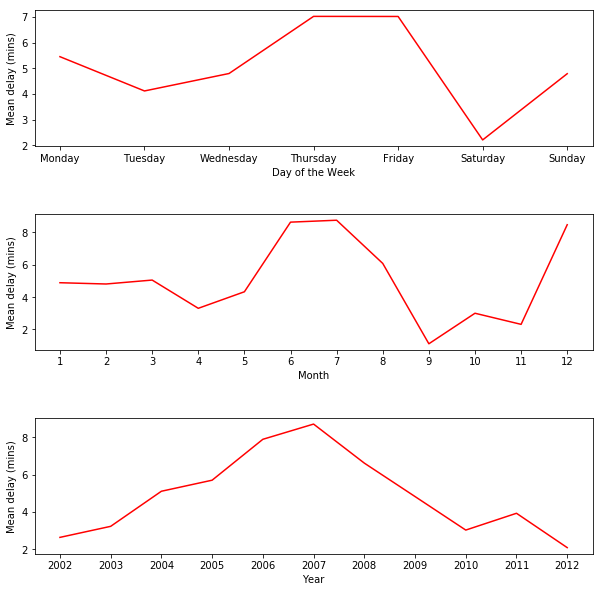

In [15]:
# Convert Date to relevant format
flights["Date"] = pd.to_datetime(flights["Date"])

# Group by day of the week
delay_day = flights.groupby(flights["Date"].dt.weekday)["Arrival_delay"]
delay_day = delay_day.describe().reset_index()

# Group by month
delay_month =flights.groupby(flights["Date"].dt.month)["Arrival_delay"]
delay_month = delay_month.describe().reset_index()

# Group by year
delay_year =flights.groupby(flights["Date"].dt.year)["Arrival_delay"]
delay_year = delay_year.describe().reset_index()




fig, ax = plt.subplots(nrows = 3, figsize = (10,10))

# Plot mean delay vs day of the week
ax[0].plot(delay_day["Date"], delay_day["mean"], color = "red")
ax[0].set_xlabel("Day of the Week")
ax[0].set_ylabel("Mean delay (mins)")
ax[0].set_xticklabels([" ","Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"])

# Plot mean delay vs month
ax[1].plot(delay_month["Date"], delay_month["mean"], color = "red")
ax[1].set_xlabel("Month")
ax[1].set_ylabel("Mean delay (mins)")
ax[1].set_xticks(np.arange(1,13))

# Plot mean delay vs year
ax[2].plot(delay_year["Date"], delay_year["mean"], color = "red")
ax[2].set_xlabel("Year")
ax[2].set_ylabel("Mean delay (mins)")
ax[2].set_xticks(np.arange(2002,2013))

fig.subplots_adjust(hspace=0.5)

plt.show()

The first plot suggests that Thursday and Friday tend to have the largest flight delays, whereas Saturday has the least.

From the month graph above, it seems that the mean delay time is significantly larger duing the June, July, August and December in comparison to other months. During the Summer, you would expect airports and flights to be more crowded as people are trying to take advantage of their Summer holidays by travelling to other countries. The increase in travellers is likely to cause more logistical issues and hence cause more delays. A similar explanation can be provided during December as people will be travelling to meet families/friends for Christmas.

The trend shown by the year graph is very interesting! It seems that there was a increasing trend in delay time between the years 2001 and 2007, but since then there has generally been a downards trend. One possible reason to explain this is that in the immediate years after 9/11, there would have been an increase in security which may have led to more delays in getting passengers through the airport and onto their flights. However, after a few years of these added security measures being in place, airports and passengers may have learnt how to be more efficient with it.


## Modelling

The second part of our analysis concerns modelling. We would like to create a machine learning model that accurately predicts a flight's delay time. As this variable is continous, this is a regression problem.  

Rather than considering the Date variable on its own, it would be worth breaking this down into 2 variables - day of the week and month. Year perhaps wouldn't be as useful to use, as if new and unseen data from a more recent year (eg, 2018) was inputted into the fitted model, the predicted result wouldn't be very accurate (the model is only fitted on data between 2002 and 2012).  Below, we create 2 new columns (Day and Month).

In [16]:
# Add Day column
flights["Day"] = flights["Date"].dt.weekday

# Add Month column
flights["Month"] = flights["Date"].dt.month

Also, it seems that the "DC_Longitude" column is exactly the same as the "Longitude" column and that the "DC_Latitude" column is exactly the same as the "Latitude" column. However, we should ensure that this is true. To do this, we subtract the 2 pairs of similar columns and check that the sum of the values is 0. 

In [17]:
print((flights["DC_Longitude"] - flights["Longitude"]).sum())
print((flights["DC_Latitude"] - flights["Latitude"]).sum())

0.0
0.0


Hence, the "DC_Longitude" column is exactly the same as the "Longitude" column, and the "DC_Latitude" column is exactly the same as the "Latitude" column. So we shall drop the "DC_Longitude" and "DC_Latitude" columns.

In addition, it would make sense to drop the "Arrival_actual" column. We are trying to predict a flight's arrival delay time so it would be pointless to use the flight's actual arrival time as a feature as the delay time would just be Arrival_actual - Arrival_schedule (both of which would be known to us); there would be no point having a machine learning model. We also drop the "Path_order" column as it is just a column of ones. It doesn't add anything useful to the model.

In [18]:
# Drop DC_Longitude and DC_Latitude columns
flights_2 = flights.drop(["DC_Longitude", "DC_Latitude", "Arrival_actual", "Path_order"], axis = 1)
flights_2.head(5)

,Date,Airline,Airline_code,Arrival_airport,Arrival_state,Departure_Airport,Departure_State,Departure_actual,Departure_delay,Arrival_delay,Arrival_schedule,Departure_schedule,Longitude,Latitude,Route,Day,Month
0,2009-04-24,9E,20363,CVG,KY,BDL,CT,1646,-4,-5,1859,1650,-72.68,41.93,CT to KY,4,4
1,2009-04-29,9E,20363,CVG,KY,BDL,CT,1640,-10,-25,1859,1650,-72.68,41.93,CT to KY,2,4
2,2010-04-30,9E,20363,CVG,KY,BDL,CT,1041,-4,-23,1310,1045,-72.68,41.93,CT to KY,4,4
3,2010-04-15,9E,20363,CVG,KY,BDL,CT,1055,10,0,1310,1045,-72.68,41.93,CT to KY,3,4
4,2010-12-24,9E,20363,CVG,KY,BDL,CT,1009,-6,-41,1242,1015,-72.68,41.93,CT to KY,4,12


It would be useful to consider some weather data for each airport too. We shall import this data below.

In [19]:
weather = pd.read_csv("weather.csv")
weather.head(5)

,Date,airport,time,temperature,snow,wind
0,2006-03-14,ORD,2041,35,NaN,18.6
1,2006-09-08,SLC,807,72,NaN,6.5
2,2006-10-22,MCO,1202,81,0.0,3.1
3,2006-10-22,MCO,602,81,0.0,3.1
4,2007-07-09,MRY,1011,64,NaN,0.7


As can be seen above, the weather dataframe contains a "time" column. As these times do not exactly match with flight times from the flights dataframe, we shall drop this column. However, this means that on a given day at a given airport, there will be a lot of duplicate weather data for each airport. Hence, we have to use the drop_duplicates function to remove these duplicates. Lastly, we convert the Date to the relevant format.

In [20]:
weather = weather.drop("time", axis = 1)
weather = weather.rename(columns = {"airport":"Departure_Airport"})
weather = weather.drop_duplicates()
weather["Date"] = pd.to_datetime(weather["Date"])

Next, we merge the weather dataframe with the flights dataframe. As both dataframes have a common "Date" and "Departure_Airport" column, the merge will take place on these 2 columns. The type of join is "inner" as we only want the merge to take place for airports which have weather data for the given day. However, it is worth noting that this leads to a large loss in flights data as a number of airports don't have any corresponding weather data for some days. 

Also, as the "snow" and "wind" columns have a number of missing values, we fill each missing value with the mean of the respective column.

In [21]:
joint_df = flights_2.merge(weather, on = ["Date", "Departure_Airport"], how = "inner")
joint_df["snow"] = joint_df["snow"].fillna(joint_df["snow"].mean())
joint_df["wind"] = joint_df["wind"].fillna(joint_df["wind"].mean())

Now, we create a dataframe called X which stores all the features. For this, we dropped the "Date" column and "Arrival_delay" column from the  joint_df dataframe. The "Date" column isn't needed as we already have a column for Day and Month'. "Arrival_delay" is the variable we're trying to predict so this is the Y dataframe.

In [22]:
# Dataframe containing features
X = joint_df.drop(["Date", "Arrival_delay"], axis = 1)

# Dataframe containing variable to predict (ie, Arrival_delay)
Y = joint_df["Arrival_delay"]

A number of the features are categorical variables. The vast majority of machine learning models within the sklearn package cannot handle categorical data. As a result, before building any models, we need to convert the categorical features into dummy variables.

In [23]:
# Convert categoric variables to dummy variables
X_dummy = pd.get_dummies(X)
X_dummy.head()

,Airline_code,Departure_actual,Departure_delay,Arrival_schedule,Departure_schedule,Longitude,Latitude,Day,Month,temperature,...,Route_WA to AZ,Route_WA to CA,Route_WA to MA,Route_WA to NC,Route_WA to OR,Route_WI to AZ,Route_WI to KY,Route_WV to KY,Route_WV to NC,Route_WY to CO
0,20363,2059,-2,2256,2101,-83.35,42.21,3,4,42,...,0,0,0,0,0,0,0,0,0,0
1,20363,1448,-2,1620,1450,-83.35,42.21,3,4,42,...,0,0,0,0,0,0,0,0,0,0
2,19386,911,4,1108,907,-83.35,42.21,3,4,42,...,0,0,0,0,0,0,0,0,0,0
3,19386,624,-2,812,626,-83.35,42.21,3,4,42,...,0,0,0,0,0,0,0,0,0,0
4,19386,854,8,1032,846,-83.35,42.21,3,4,42,...,0,0,0,0,0,0,0,0,0,0


We want to create a model that performs well on unseen data. However, in reality, we won't have access to unseen data. This is where technqiues such as splitting the data into 2 sets (training and testing) or cross validation come in.

We shall try the technique of splitting the data into 2 sets. The testing set will contain 25% of the observations and the training set will contain 75% of the observations.

In [24]:
# Split into train and test sets
X_train, X_test, Y_train, Y_test = train_test_split(X_dummy, Y, test_size=.25, random_state=0)

For this exercise, we will consider 3 different regression techniques - linear regression, random forests and KNN. The models are initialised here.

In [25]:
# Initialise the 3 regression models
lin_reg = linear_model.LinearRegression()
rand_for = RandomForestRegressor()
neigh = KNeighborsRegressor()

We then fit the models on the training data and then see how they perform on the testing data.

In [26]:
# Linear Regression
lin_reg.fit(X_train, Y_train)
lin_reg_pred = lin_reg.predict(X_test)
print("Linear Regression Test MSE Estimate: " + str(mean_squared_error(lin_reg_pred,Y_test)))
print("Linear Regression Test R-squared Estimate: " + str(r2_score(lin_reg_pred, Y_test)))


Linear Regression Test MSE Estimate: 196.395247815
Linear Regression Test R-squared Estimate: 0.80900106094


In [27]:
# KNN
neigh.fit(X_train, Y_train)
KNN_pred = neigh.predict(X_test)
print("KNN Test MSE Estimate: " + str(mean_squared_error(KNN_pred,Y_test)))
print("KNN Test R-squared Estimate: " + str(r2_score(KNN_pred, Y_test)))

KNN Test MSE Estimate: 200.51911244
KNN Test R-squared Estimate: 0.780036509326


In [28]:
# Random Forest
rand_for.fit(X_train, Y_train)
rand_for_pred = rand_for.predict(X_test)
print("Random Forest Test MSE Estimate: " + str(mean_squared_error(rand_for_pred,Y_test)))
print("Random Forest Test R-squared Estimate: " + str(r2_score(rand_for_pred, Y_test)))

Random Forest Test MSE Estimate: 184.512032822
Random Forest Test R-squared Estimate: 0.81988136932


As can be seen above, all 3 models perform very similarly to each other. To try and get a better idea of the quality of the model's predictions, we plot the true values vs predicted values for each model below. The red line corresponds to the y = x line. ie, it indicates what the "perfect" model performance would look like. 

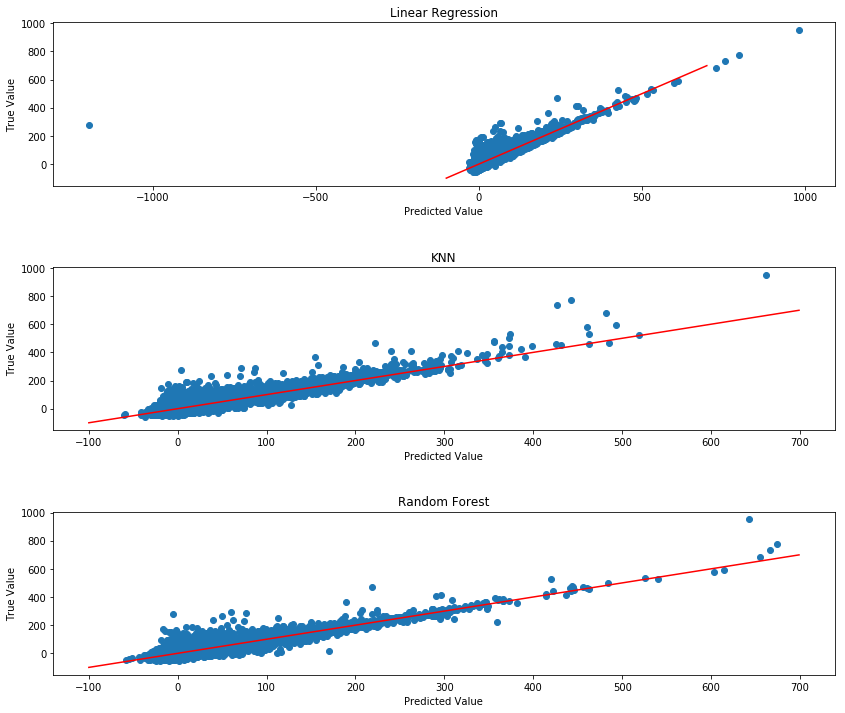

In [29]:
fig, ax = plt.subplots(nrows = 3, figsize = (14,12))

# Plotting true value vs predicted value for Linear Regression
ax[0].scatter(lin_reg_pred, Y_test)
# Plotting Y=X line. "Perfect" prediction.
x = np.arange(-100,700)
ax[0].plot(x, x, color = "red")
ax[0].set_xlabel("Predicted Value")
ax[0].set_ylabel("True Value")
ax[0].set_title("Linear Regression")

# Plotting true value vs predicted value for KNN
ax[1].scatter(KNN_pred, Y_test)
ax[1].plot(x, x, color = "red")
ax[1].set_xlabel("Predicted Value")
ax[1].set_ylabel("True Value")
ax[1].set_title("KNN")

# Plotting true value vs predicted value for Random Forest. 
ax[2].scatter(rand_for_pred, Y_test)
ax[2].plot(x, x, color = "red")
ax[2].set_xlabel("Predicted Value")
ax[2].set_ylabel("True Value")
ax[2].set_title("Random Forest")

fig.subplots_adjust(hspace=0.5)

plt.show()

It seems that the linear regression (apart from the one observation that was poorly predicted) and random forest models have the most consistent residual pattern. The KNN seem to consistently under-predict the larger delays.

Hence, if the main aim of this model is prediction, it would be best to pick the Random Forest model. If you are more conernced with picking an interpretable model, it may be best to pick the Linear Regression model as they are very easy to interpret and explain to a client who comes from a non-technical background. 

### Conclusion

To conclude, we managed to find a number of interesting insights.

* It seems that NW airline is the worst performing airline in terms of punctuality.
* Out of all airports with more than 100 flight departures, airport LMT is the worst in terms of flight punctuality.
* Out of all the routes with more than 100 flights, route NJ to OK is the worst in terms of flight punctuality.
* Thursday and Friday tend to have the largest flight delays. Saturday has the least.
* The Summer months and December have the largest flight delays.
* The mean delay time increased between the years 2002 and 2007 and then generally decreased from there onwards.
* Linear Regression, KNN and Random Forest all seem to perform fairly well in predicting arrival delay.
* If concerned with prediction accuracy, Random Forest would be the best model to pick.
* If concerned with intepretation of the model, would be worth picking the linear regression model.

### Improvements

* Try to think of a way of using the weather data without losing observations from the flights data set. 
* Perhaps perform feature selection? Thought it wasn't possible to do this when dummy variables are present.
* Worth trying Cross Validation to estimate test MSE rather than simply splitting the data into 2 sets. This would give a more accurate test MSE estimate - the variance of the estimate is a lot smaller.  
* Experiment with each model's parameters. Eg, maybe the default K (K = 5) for KNN isn't the best K to use here.
